#### Downloaded the data and extracted the zip file.

In [2]:
import zipfile

file = 'data/cal_housing.data.zip'
efile = 'data'

with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall(efile)



### Importing the relevant libraries.

In [1]:
import os
import pandas as pd 
import numpy as np 

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F 
from pyspark.sql.functions import udf, col


from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics


from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator 


In [2]:
import seaborn as sns 
import matplotlib.pyplot as pl

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### setting random seed for notebook reproducability


In [4]:
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

#### Creating spark Session

In [7]:
spark = SparkSession.builder.appName("Linear-Regression-California-Housing").getOrCreate()

23/09/23 21:47:51 WARN Utils: Your hostname, xavier-ROG-Strix-G531GT-G531GT resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlo1)
23/09/23 21:47:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/23 21:47:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
spark

### Entering Housing data

In [9]:
HOUSING_DATA = 'data/cal_housing.data'

In [20]:
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)
])

In [21]:
housing_data = spark.read.csv(path=HOUSING_DATA, schema=schema, header=True)


In [22]:
housing_data.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



In [23]:
housing_data.cache()

23/09/23 22:30:13 WARN CacheManager: Asked to cache already cached data.


DataFrame[long: float, lat: float, medage: float, totrooms: float, totbdrms: float, pop: float, houshlds: float, medinc: float, medhv: float]

In [24]:
housing_data.take(5)

[Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=919.0, totbdrms=213.0, pop=413.0, houshlds=193.0, medinc=4.036799907684326, medhv=269700.0)]

In [25]:
housing_data.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [28]:
housing_data.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

#### Data Exploration.

In [29]:
housing_data.select('pop', 'totbdrms').show()

+------+--------+
|   pop|totbdrms|
+------+--------+
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
| 910.0|   434.0|
|1504.0|   752.0|
|1098.0|   474.0|
| 345.0|   191.0|
|1212.0|   626.0|
| 697.0|   283.0|
| 793.0|   347.0|
| 648.0|   293.0|
| 990.0|   455.0|
| 690.0|   298.0|
| 409.0|   184.0|
+------+--------+
only showing top 20 rows



In [31]:
# group by housingmedianage and see the distribution
result_df = housing_data.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



<Axes: xlabel='medage'>

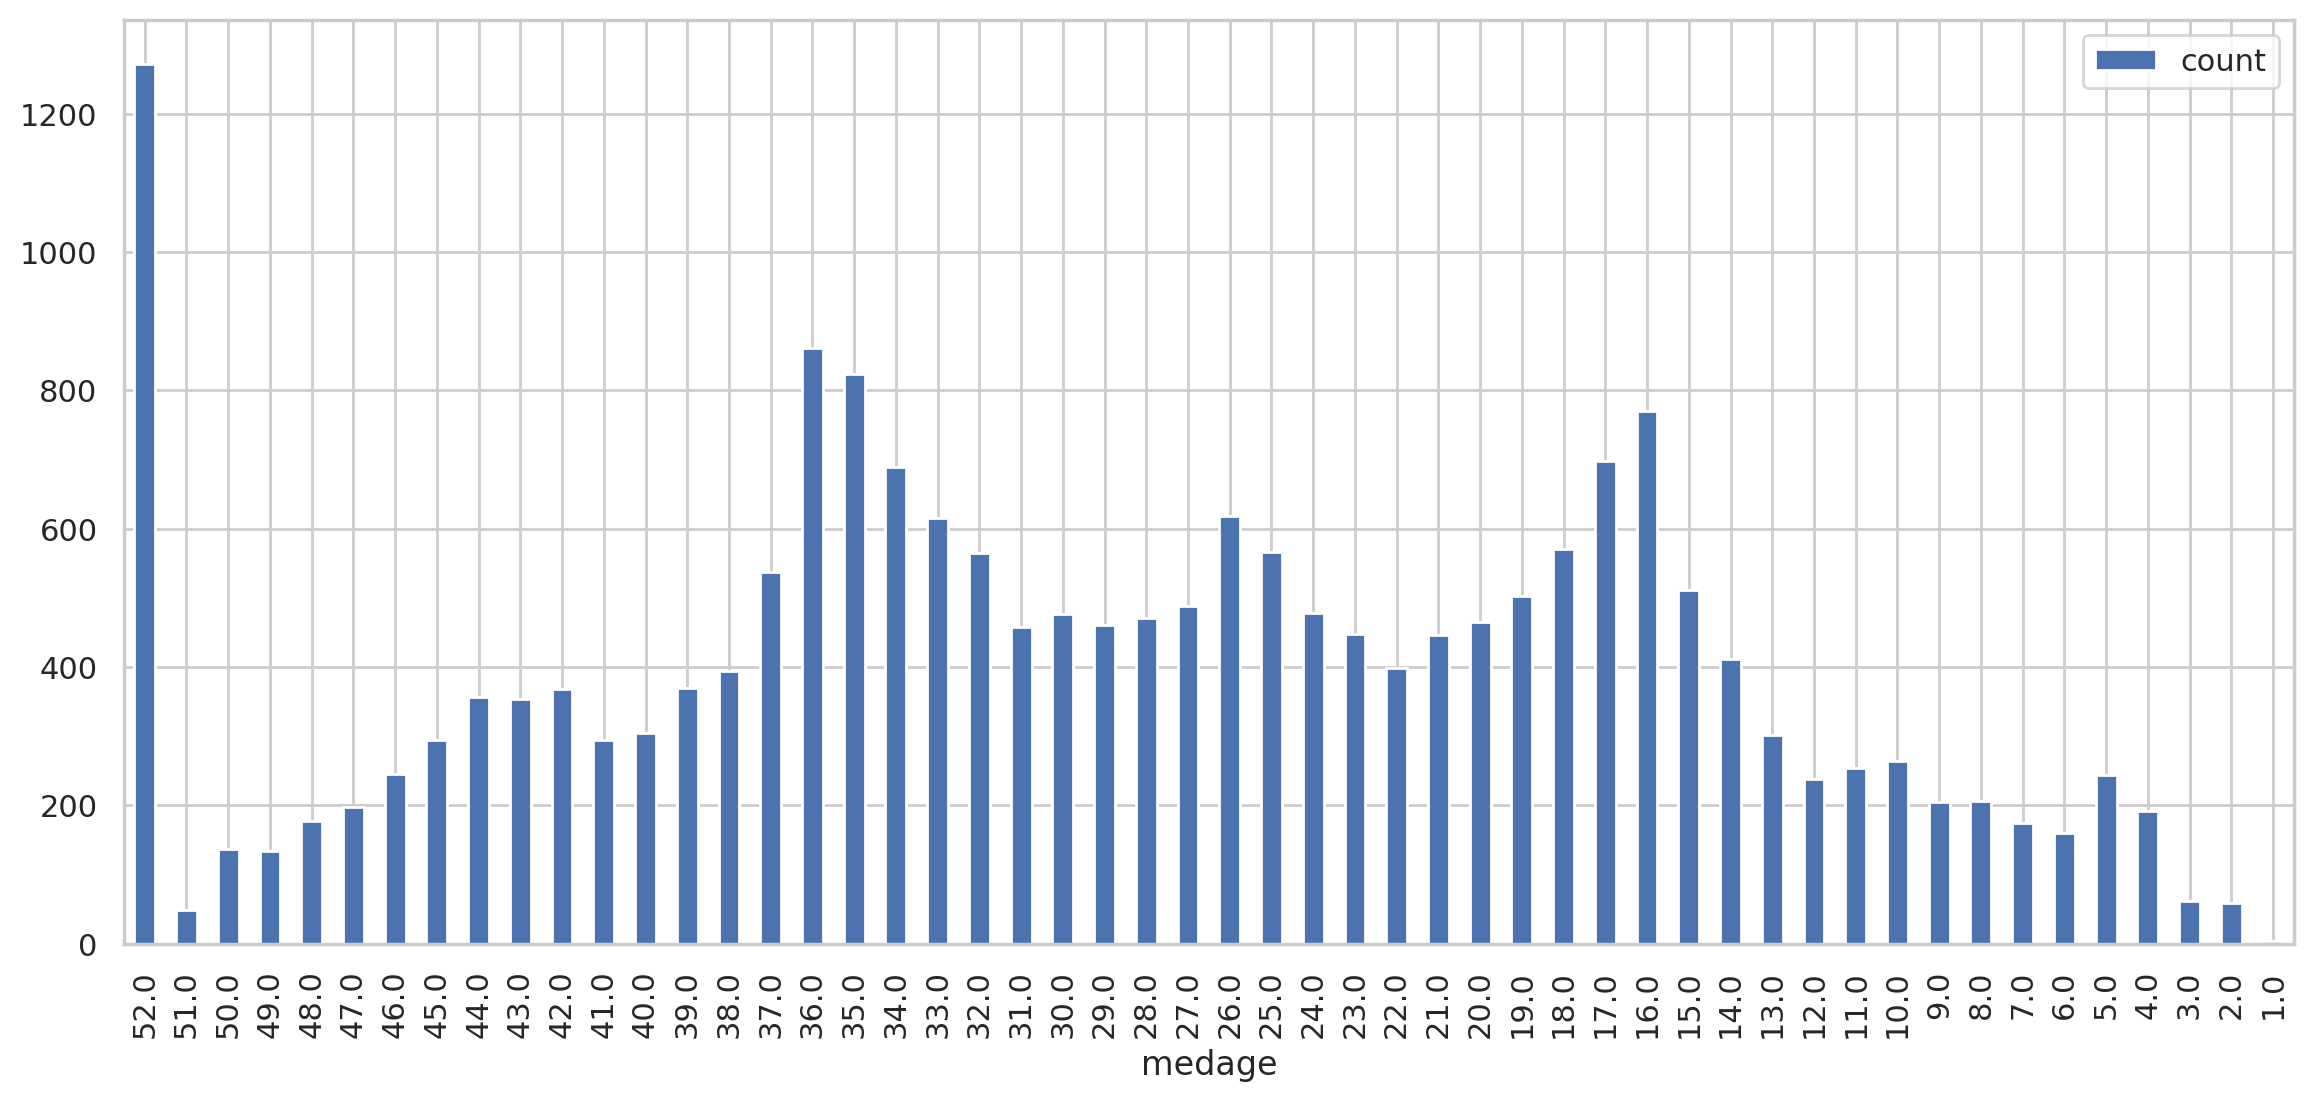

In [32]:
result_df.toPandas().plot.bar(x='medage', figsize=(14,6))

##### As We can observe from the above graph that most of the resident are young people between 17 Years and 36 Years. Also, It can be observed that the second largest set of people is from the senior citizen group.

In [36]:
housing_data.describe().select(
    "summary",
    F.round("medage", 4).alias("medage"),
    F.round("totrooms", 4).alias("totrooms"),
    F.round("totbdrms", 4).alias("totbdrms"),
    F.round("pop", 4).alias("pop"),
    F.round("houshlds", 4).alias("houshlds"),
    F.round("medinc", 4).alias("memedincdage"),
    F.round("medhv", 4).alias("medhv")
).show()

+-------+-------+---------+--------+---------+--------+------------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds|memedincdage|      medhv|
+-------+-------+---------+--------+---------+--------+------------+-----------+
|  count|20639.0|  20639.0| 20639.0|  20639.0| 20639.0|     20639.0|    20639.0|
|   mean|28.6389|2635.8482|537.9178|1425.5302|499.5578|      3.8705|206843.9101|
| stddev|12.5856|2181.6339|421.2485|1132.4635|382.3302|      1.8996|115385.7317|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0|      0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|     15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+------------+-----------+

